In [ ]:
# Experiments to run
# 1: Show the problem in treating images as independent
# 1.1 Use the C set. Mix the images randomly, establish a training/validation/test set (60%/20%/20%)
# Show that just picking images randomly is a bad idea, because our algorithm will learn to generalise
# from the object/location to the class, instead of interesting attributes
# 1.2 Use the C set. Establish a training/validation/test set (60%/20%/20%), but assign objects instead of images

# 2: Show the effect on generalisation between geometries/builds
# 2.1 Same as 1.2
# 2.2 Same as 2.1, but include the A and B set in the training data

# 3: Show the effect of using corners (or not)
# 3.1 Same as 1.2
# 3.2 Use corners, show the result is worse. There is a need to account for the location of the outlier - outliers near the edge are expected.
# Can we do some form of higher-order outlier detection? (e.g. if there are 2 outliers, and they are close to each other, they are probably not outliers)
# Realistically, because of the size of the edges that may be tricky. 
# Before making grandiouse conclusions, validate that the outlier value image makes sense and that it's not some bug or artithmetic error because of my method.
# Never assume the code works :)

# 4: For the best performing setting, show the execution time/accuracy tradeoff and do the cost calculations

# Each cell should (ideally) be self-contained, to facilitate re-running parts of the experiments

knn_k3_p1_n_jobs-1_nd3_bo10: 0.49938305840945424
knn_k3_p2_n_jobs-1_nd3_bo10: 0.5002079282140313
knn_k5_p1_n_jobs-1_nd3_bo10: 0.5134604534530627
knn_k5_p2_n_jobs-1_nd3_bo10: 0.510681859082539
knn_k7_p1_n_jobs-1_nd3_bo10: 0.5097102366773146
knn_k7_p2_n_jobs-1_nd3_bo10: 0.5110069675724841


KeyboardInterrupt: 

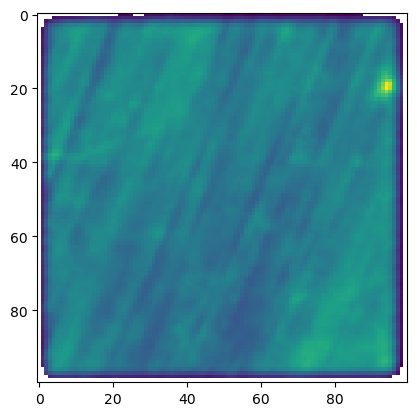

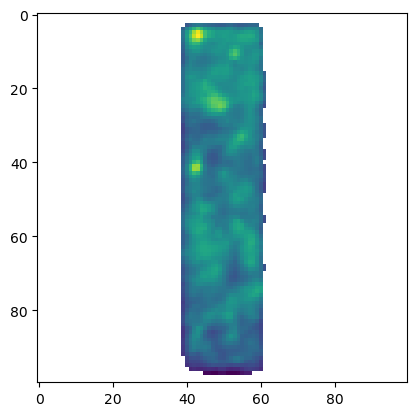

<Figure size 640x480 with 0 Axes>

In [32]:
# 1.1
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import time
# Parameters
threshold = 10000 # determine this...
windowSize = 1
windowAdvance = 1
odtype = 'moran'
neighbourhoodDistance = 1
neighbourhoodZ = 1
emptyRatioB = 30

# Hyperparameters
neighbourhoodDistances = [3, 5]
binOptions = [10, 20, 40]

# Contstants
bend = 225
objectwidth = 100
objectheight = 100
twindowSize = windowSize
twindowAdvance = windowAdvance

%run classes.ipynb

X = readCSet()
# Cheating background elimination to try things out. Change later if the result is interesting
calc_threshold = np.percentile(X, 30)
mask = np.average(X, axis=(0))
for i, o in enumerate(X):
    # plt.imshow(o[0])
    # plt.figure()
    # plt.imshow(mask[0])
    # plt.figure()
    # plt.imshow(np.where(mask < calc_threshold, np.nan, o)[0])
    # plt.figure()
    # plt.imshow(o[224])
    # plt.figure()
    # plt.imshow(mask[224])
    # plt.figure()
    # plt.imshow(np.where(mask < calc_threshold, np.nan, o)[224])
    X[i] = np.where(mask < calc_threshold, np.nan, X[i])
    # plt.figure()
    # plt.imshow(X[i][0])
    # plt.figure()
    # plt.imshow(X[i][224])
    # plt.figure()
# End of cheating

X = X.reshape(-1, objectwidth, objectheight)
labelRanges = [(i, i+twindowSize) for i in range(0, bend-twindowSize+1, twindowAdvance)]
y = [getLabelsC(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,26)]

# Show images, ensure they look all right
plt.imshow(X[0])
plt.figure()
plt.imshow(X[-3])
plt.figure()
# Do the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
skf = StratifiedKFold(n_splits=5)

knn_k = [3, 5, 7, 9]
knn_p = [1, 2]
knn_n_jobs = [-1]
rf_n_estimators = [50, 100, 200]
rf_random_state = [42]
rf_n_jobs = [-1]
dt_max_depth = [10, 20, 40, 80, 160]
dt_random_state = [42]
svc_C = [0.1, 1, 10, 100]
svc_random_state = [42]

classifiers = []
for k in knn_k:
    for p in knn_p:
        for n_jobs in knn_n_jobs:
            classifiers.append(('knn_k{}_p{}_n_jobs{}'.format(k, p, n_jobs), KNeighborsClassifier(n_neighbors=k, p=p, n_jobs=n_jobs)))
for n_estimators in rf_n_estimators:
    for random_state in rf_random_state:
        for n_jobs in rf_n_jobs:
            classifiers.append(('rf_n_estimators{}_random_state{}_n_jobs{}'.format(n_estimators, random_state, n_jobs), RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, n_jobs=n_jobs)))
for max_depth in dt_max_depth:
    for random_state in dt_random_state:
        classifiers.append(('dt_max_depth{}_random_state{}'.format(max_depth, random_state), DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)))
for C in svc_C:
    for random_state in svc_random_state:
        classifiers.append(('svc_C{}_random_state{}'.format(C, random_state), SVC(C=C, random_state=random_state)))

df = pd.DataFrame(columns=['model', 'score'])
for nd in neighbourhoodDistances:
    for bo in binOptions:
        for name, clf in classifiers:
            # Todo: add more hyperparameters
            cvalscores = []
            for train, validation in skf.split(X_train, y_train):
                crosstrainX = X_train[train]
                crossvalX = X_train[validation]
                crosstrainY = y_train[train]
                crossvalY = y_train[validation]
                # Train with a bunch of different hyperparameters, with cross-validation on 60% of the data
                calc_threshold = np.percentile(crosstrainX, 30)
                bgr = backgroundRemover2(calc_threshold)
                #ab = blockAccumulator(windowSize, windowAdvance)
                oc1 = outlierCalculator(odtype, nd, neighbourhoodZ)
                #sansBackground = bgr.removeBackground(crosstrainX)
                sansBackground = crosstrainX
                sansBackground = np.array([crosstrainX])
                sansBackground = np.moveaxis(sansBackground, 1, 0)
                # Beräkna Ocval för alla bilder i träningssetet
                ocs = oc1.calculate(sansBackground)
                # AB accumulation would normally happen here
                # Räkna ut min och max för ocval
                ocmin = np.nanmin(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in ocs]))
                ocmax = np.nanmax(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in ocs]))
                e1 = encoder(bo, ocmin, ocmax)
                # Skapa histogrammen för träningssetet
                hists = e1.encode(ocs)
                # Kör ML grejer (kan effektivisera genom att bara iterera över deras hyperparametrar här)
                scaler = StandardScaler()
                pipe = Pipeline([('scaler', scaler), ('classifier', clf)])
                pipe.fit(hists, crosstrainY)
                # End of training

                # Kör på valideringssetet
                #sansBackground = bgr.removeBackground(crossvalX)
                sansBackground = np.array([crossvalX])
                sansBackground = np.moveaxis(sansBackground, 1, 0)
                ocs = oc1.calculate(sansBackground)
                hists = e1.encode(ocs)
                score = roc_auc_score(crossvalY, pipe.predict_proba(hists)[:,1])
                cvalscores.append(score)
                # Lägg resultatet från folden i cvalscores (den kommer behöva utökas för att ta med fler ML modeller...)
            # Räkna ut genomsnittlig performance för uppsättningen hyperparametrar, spara ned
            df.loc[len(df.index)] = {
                'model': '{}_nd{}_bo{}'.format(name, nd, bo),
                'score': np.mean(cvalscores)
            }
            print('{}_nd{}_bo{}: {}'.format(name, nd, bo, np.mean(cvalscores)))
